# Import Data and Train Model


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
from transformers import get_scheduler, AdamW
from datasets import load_metric

import numpy as np
import librosa

import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd;
import numpy as np
import math

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import mne.channels
from tqdm.auto import tqdm
import random

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

c:\Users\loicl\Documents\UniWork\Year 3\Dissertation\TinyML-for-Epileptic-Seizures\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Data: Create Dataset


### Load Absence Seizure Data


In [4]:
class AbsenceDataset(Dataset):
    def __init__(self, file_path, transform=None, target_transform=None):
        self.x, self.y = self.data_get(file_path)
        self.n_samples = len(self.x)

        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, idx):
        sample_x, sample_y = self.x[idx], self.y[idx]

        if self.transform:
            sample_x = self.transform(sample_x)

        if self.target_transform:
            sample_y = self.target_transform(sample_y)

        return sample_x.float(), sample_y.float()

    def __len__(self):
        return self.n_samples

    def data_get(self, file_path):
        data = pd.read_csv(file_path)
        x_loaded, y_loaded = [], []
        for index, row in data.iterrows():
            a = np.load(row["labels"])
            for i, v in enumerate(a):
                a[i] = int(v)
            y_loaded.append(a)

            x_loaded.append(np.load(row["data"]))

        continuous_x = np.concatenate(x_loaded, axis=0)
        continuous_y = np.concatenate(y_loaded, axis=0)

        return continuous_x, continuous_y

In [5]:
%%capture
# Load the dataset
seizure_type = "tonic-clonic"
dataset = AbsenceDataset(
    f"processed_data/{seizure_type}/two_second_windows/epochs_files.csv",
    transform=torch.tensor,
    target_transform=torch.tensor,
)
dataset.y = dataset.y.astype(int)

In [6]:
dataset.x.shape

(204, 5, 800)

# Split Data

70%, 20%, 10%


In [7]:
dataset_len = len(dataset)
dataset_len

204

In [9]:
if (
    int(dataset_len * 0.7) + int(dataset_len * 0.2) + int(dataset_len * 0.1)
) != dataset_len:
    train_set, eval_set, test_set = random_split(
        dataset,
        [
            math.ceil(dataset_len * 0.7),
            int(dataset_len * 0.2),  # math.ceil
            int(dataset_len * 0.1),
        ],
    )
else:
    train_set, eval_set, test_set = random_split(
        dataset,
        [
            int(dataset_len * 0.1),
            int(dataset_len * 0.7),
            int(dataset_len * 0.2),
        ],
    )

print(f"Train Split: {len(train_set)}")
print(f"Eval Split: {len(eval_set)}")
print(f"Test Split: {len(test_set)}")
print(f"Total: {len(train_set) + len(eval_set) + len(test_set)}")

Train Split: 143
Eval Split: 41
Test Split: 20
Total: 204


In [10]:
train_set.dataset.x[train_set.indices].shape, train_set.dataset.y[
    train_set.indices
].shape

((143, 5, 800), (143,))

## SMOTE


In [11]:
bk, sz = 0, 0
for i, v in enumerate(train_set.dataset.y[train_set.indices]):
    if v == 1:
        sz += 1
    else:
        bk += 1

print(f"Background: {bk} // Absence Seizure: {sz}")

Background: 69 // Absence Seizure: 74


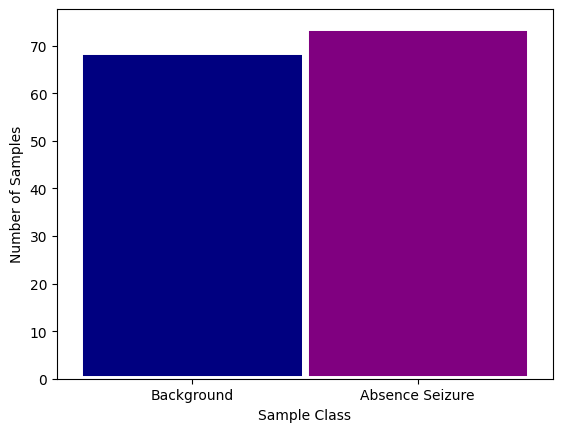

In [12]:
n, bins, p = plt.hist(
    train_set.dataset.y[train_set.indices],
    bins=2,
    edgecolor="white",
    linewidth=5,
    range=(0, 1),
)
plt.xticks([0.25, 0.75], ["Background", "Absence Seizure"])
plt.ylabel("Number of Samples")
plt.xlabel("Sample Class")
p[0].set_facecolor("navy")
p[1].set_facecolor("purple")

In [13]:
shape = train_set.dataset.x[train_set.indices].shape
data_reshaped = train_set.dataset.x[train_set.indices]
data_reshaped = np.reshape(data_reshaped, (shape[0], shape[1] * shape[2]))
data_reshaped.shape

(143, 4000)

In [14]:
train_set_x, train_set_y = SMOTE(
    sampling_strategy="minority", random_state=42
).fit_resample(data_reshaped, train_set.dataset.y[train_set.indices])

In [12]:
# rand_us = RandomUnderSampler(random_state=42)
# train_set_x, train_set_y = rand_us.fit_resample(
#     data_reshaped, train_set.dataset.y[train_set.indices]
# )

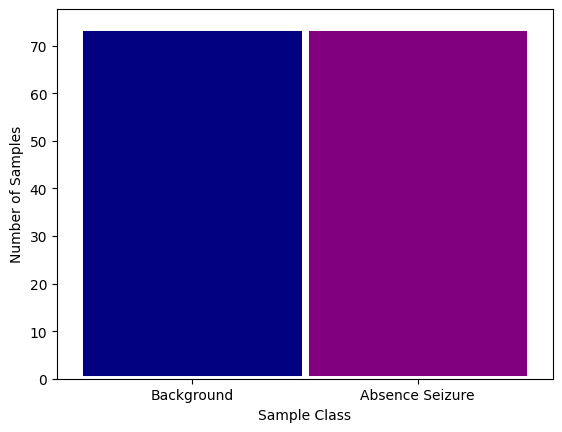

In [15]:
n, bins, p = plt.hist(
    train_set_y,
    bins=2,
    edgecolor="white",
    linewidth=5,
    range=(0, 1),
)
plt.xticks([0.25, 0.75], ["Background", "Absence Seizure"])
plt.ylabel("Number of Samples")
plt.xlabel("Sample Class")
p[0].set_facecolor("navy")
p[1].set_facecolor("purple")

In [16]:
train_set_x = np.reshape(train_set_x, (train_set_x.shape[0], shape[1], shape[2]))
val_set_x = eval_set.dataset.x[eval_set.indices]
train_set_x.shape, val_set_x.shape

((148, 5, 800), (41, 5, 800))

In [17]:
bk, sz = 0, 0
for i, v in enumerate(train_set_y):
    if v == 1:
        sz += 1
    else:
        bk += 1

print(f"Background: {bk} // Absence Seizure: {sz}")

Background: 74 // Absence Seizure: 74


# STFT


Create STFT


In [18]:
n_fft = int(512 / 2)
window = "taylor"
hop_length = int(n_fft / 6)
fmin = 0
fmax = 5
n_mels = 7
sample_rate = 250

# Train
stft_channel_data = []
for i, channels in enumerate(train_set_x):
    stft_channel_data.append(
        (
            librosa.feature.melspectrogram(
                y=channels,
                sr=sample_rate,
                n_mels=n_mels,
                n_fft=n_fft,
                fmin=fmin,
                fmax=fmax,
                hop_length=hop_length,
                window=window,
                center=True,
                pad_mode="constant",
                power=3.0,
            )
        )
    )
stft_channel_data = np.array(stft_channel_data)

# Val
val_stft_channel_data = []
for i, channels in enumerate(val_set_x):
    val_stft_channel_data.append(
        (
            librosa.feature.melspectrogram(
                y=channels,
                sr=sample_rate,
                n_mels=n_mels,
                n_fft=n_fft,
                fmin=fmin,
                fmax=fmax,
                hop_length=hop_length,
                window=window,
                center=True,
                pad_mode="constant",
                power=3.0,
            )
        )
    )
val_stft_channel_data = np.array(val_stft_channel_data)

stft_channel_data.shape, val_stft_channel_data.shape

((148, 5, 7, 20), (41, 5, 7, 20))

In [19]:
# Train
train_db = []
for i, channels in enumerate(stft_channel_data):
    train_db.append(librosa.amplitude_to_db((channels), ref=np.max))
train_db = np.array(train_db)

# Val
val_db = []
for i, channels in enumerate(val_stft_channel_data):
    val_db.append(librosa.amplitude_to_db((channels), ref=np.max))
val_db = np.array(val_db)

train_db.shape, val_db.shape

((148, 5, 7, 20), (41, 5, 7, 20))

In [20]:
# Train
train_db_mean = []
for i, channels in enumerate(stft_channel_data):
    train_db_mean.append(np.mean(channels, axis=0))
train_db_mean = np.array(train_db_mean)

# Val
val_db_mean = []
for i, channels in enumerate(val_stft_channel_data):
    val_db_mean.append(np.mean(channels, axis=0))
val_db_mean = np.array(val_db_mean)

train_db_mean.shape, val_db_mean.shape

((148, 7, 20), (41, 7, 20))

In [30]:
print(train_set_y)

[1 0 1 0 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 0 0 1 0 0 1 0 1 1 1 0 1 0 0 1 1 1
 1 1 0 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1 0 0 0 1 0 1 1 0 1 1 0 0 0 0 0 0 0
 0 0 1 0 1 0 0 0 0 0 1 0 0 1 1 1 0 1 1 1 1 0 0 1 1 1 0 1 1 0 1 0 0 1 1 0 1
 1 0 0 0 1 1 0 1 1 0 0 1 0 0 0 1 1 0 0 1 1 1 1 1 0 0 0 1 1 1 1 1 0 0 0 0 0]


0


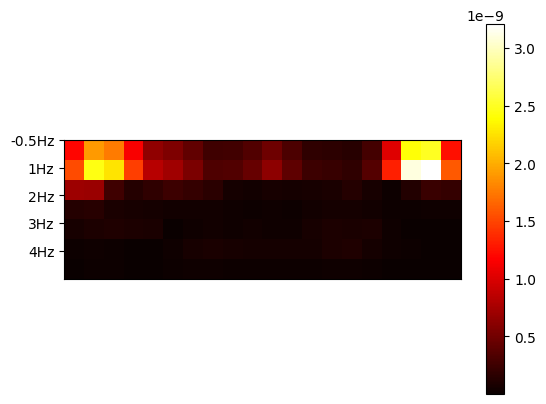

In [196]:
x = 90
print(train_set_y[x])
plt.imshow(train_db_mean[x], cmap="hot")
tick_list = [-0.5]
label_list = ["-0.5Hz"]
for i in range(fmax):
    if i != 0:
        tick_list.append((n_mels / fmax) * i - 0.5)
        label_list.append(f"{i}Hz")
plt.yticks(tick_list, labels=label_list)
plt.xticks([])
plt.colorbar()

Text(0.5, 1.0, 'Raw Channels')

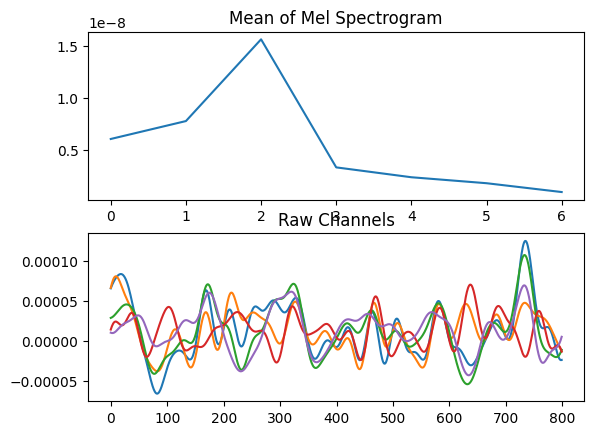

In [190]:
plt.subplot(2, 1, 1)
plt.plot(np.mean(train_db_mean[x], axis=1))
plt.title("Mean of Mel Spectrogram")
plt.subplot(2, 1, 2)
for i in train_set_x[x]:
    plt.plot(i)
plt.title("Raw Channels")

Convert STFT to Image for Input


In [191]:
from skimage import io
from sklearn import preprocessing

In [192]:
def sklearn_minnax(min, max, X):
    X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
    X_scaled = X_std * (max - min) + min
    return X_scaled

In [193]:
train_input_x = []
for i, melspec in enumerate(train_db_mean):
    img = 255 - (sklearn_minnax(0, 255, melspec).astype(np.uint8))
    img = np.repeat(img[..., np.newaxis], 3, -1)
    img = np.transpose(img, (2, 0, 1))
    train_input_x.append(img.astype(np.uint8))
train_input_x = np.array(train_input_x)

val_input_x = []
for i, melspec in enumerate(val_db_mean):
    img = 255 - (sklearn_minnax(0, 255, melspec).astype(np.uint8))
    img = np.repeat(img[..., np.newaxis], 3, -1)
    img = np.transpose(img, (2, 0, 1))
    val_input_x.append(img.astype(np.uint8))
val_input_x = np.array(val_input_x)

0


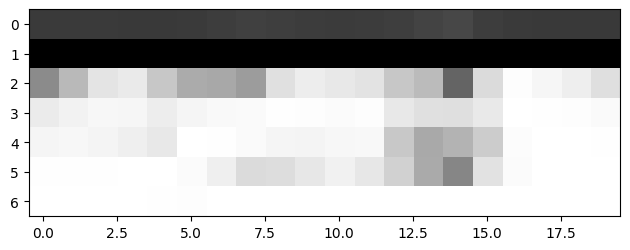

In [197]:
io.imshow(np.transpose(train_input_x[x], (1, 2, 0)))
print(train_set_y[x])

# Remake Dataset


In [24]:
class BalancedDataset(Dataset):
    def __init__(self, data, transform=None, target_transform=None):
        self.x, self.y = data
        self.n_samples = len(self.x)

        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, idx):
        sample_x, sample_y = self.x[idx], self.y[idx]

        if self.transform:
            sample_x = self.transform(sample_x)

        if self.target_transform:
            sample_y = self.target_transform(sample_y)

        return sample_x.float(), sample_y.float()

    def __len__(self):
        return self.n_samples

In [25]:
train_dataset = BalancedDataset(
    (train_input_x, train_set_y),
    transform=torch.tensor,
    target_transform=torch.tensor,
)
eval_dataset = BalancedDataset(
    (val_input_x, eval_set.dataset.y[eval_set.indices]),
    transform=torch.tensor,
    target_transform=torch.tensor,
)

In [26]:
# # Train
# train_db = []
# for i, channels in enumerate(stft_channel_data):
#     train_db.append(librosa.amplitude_to_db((channels), ref=np.max))
# train_db = np.array(train_db)

# # Val
# val_db = []
# for i, channels in enumerate(val_stft_channel_data):
#     val_db.append(librosa.amplitude_to_db((channels), ref=np.max))
# val_db = np.array(val_db)

# train_db.shape, val_db.shape

# DataLoaders


In [27]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=15,
    shuffle=True,
)
eval_dataloader = DataLoader(dataset=eval_dataset, batch_size=15, shuffle=True)
test_dataloader = DataLoader(dataset=test_set, batch_size=15, shuffle=True)

# Model

Mobilenet


In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [29]:
from torchvision.models import mobilenet_v2

In [30]:
model = mobilenet_v2()
model.classifier[1] = nn.Linear(1280, 2)
model = nn.Sequential(
    model,
    nn.Softmax(dim=1),
)
model = model.to(device)

c = 0
for i, v in enumerate((model.parameters())):
    c += 1
print(c)

model

158


Sequential(
  (0): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1, 1), s

# Train


## Training Loop


### Print Inputs


In [31]:
# Plot distribution of the dataset before balancing
# 0 - Background epoch
# 1 - Absence seizure epoch

bk = 0
sz = 0
for i, v in enumerate(train_dataloader):
    for i in v[1]:
        if i == torch.tensor([1.0]):
            sz += 1
        else:
            bk += 1

print(f"Train // Background: {bk} // Absence Seizure: {sz}")

bk = 0
sz = 0
for i, v in enumerate(eval_dataloader):
    for i in v[1]:
        if i == torch.tensor([1.0]):
            sz += 1
        else:
            bk += 1

print(f"Validation // Background: {bk} // Absence Seizure: {sz}")

Train // Background: 5544 // Absence Seizure: 5544
Validation // Background: 1608 // Absence Seizure: 50


### Training


In [32]:
for i, v in enumerate(eval_dataloader):
    first_input = v[0]
    first_label = v[1]
    break

print(first_input.shape, first_label, type(first_input))
# print(first_input.squeeze())

for i, v in enumerate(train_dataloader):
    first_input = v[0]
    first_label = v[1]
    break

print(first_input.shape, first_label)

# test_sample = test_sample.squeeze()
# test_sample = test_sample.numpy()
# print(test_sample.shape)
# io.imshow(test_sample)
# io.imsave("test_sample.png", test_sample.astype(np.uint8))

torch.Size([15, 3, 7, 12]) tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]) <class 'torch.Tensor'>
torch.Size([15, 3, 7, 12]) tensor([0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0.])


In [33]:
num_epochs = 200
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_fn = nn.CrossEntropyLoss()
scheduler = get_scheduler(
    "linear",
    optimizer,
    num_warmup_steps=0,
    num_training_steps=num_epochs * len(train_dataloader),
)

In [34]:
print(device)

cuda


In [35]:
# for batch in train_dataloader:
#         inputs, labels = batch
#         inputs, labels = inputs.to(device), labels.to(device)
#         plt.plot(inputs[0].cpu().numpy())
#         print(labels)
#         break

In [36]:
progress_bar = tqdm(range(num_epochs * len(train_dataloader)))

loss_track = []
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    loss_batch = []
    for batch in train_dataloader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.to(torch.int64)
        # inputs = inputs.squeeze()
        # print(inputs.shape, labels.shape)

        optimizer.zero_grad()
        outputs = model(inputs)
        del inputs

        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        scheduler.step()
        progress_bar.update(1)

        loss_batch.append(loss)

        del outputs, labels, loss

    loss_track.append(sum(loss_batch) / len(loss_batch))
    # break
    torch.cuda.empty_cache()

print("Done")

100%|█████████▉| 147997/148000 [1:06:45<00:00, 37.23it/s]

Done


In [37]:
metric = load_metric("glue", "mrpc")
model.eval()
c, n = 0, 0
results_list = []
valid_loss = []
for i in range(num_epochs):
    running_loss = []
    for batch in eval_dataloader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.to(torch.int64)

        with torch.no_grad():
            outputs = model(inputs)

        results_list.append(outputs)

        running_loss.append(loss_fn(outputs, labels).item())

        for i, v in enumerate(outputs):
            if labels[i] == torch.tensor([1]).to(device):
                if v[1] > v[0]:
                    c += 1
                else:
                    n += 1
            else:
                if v[0] > v[1]:
                    c += 1
                else:
                    n += 1

    valid_loss.append(sum(running_loss) / len(running_loss))

    # logits = outputs.logits
    # predictions = torch.argmax(logits, dim=-1)
    # metric.add_batch(predictions=outputs, references=labels)

# results = metric.compute()
# for i, v in enumerate(eval_dataloader):
#     if v[1].squeeze() == torch.tensor([1.0]):
#         print(results_list[i])

C:\Users\loicl\AppData\Local\Temp\ipykernel_21720\4104572702.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("glue", "mrpc")
c:\Users\loicl\Documents\UniWork\Year 3\Dissertation\TinyML-for-Epileptic-Seizures\.venv\Lib\site-packages\datasets\load.py:756: FutureWarning: The repository for glue contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/glue/glue.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
100%|██████████| 148000/148000 [1:07:03<00:00, 37.23it/s]

In [40]:
print(f"Correct: {c}")
print(f"Not Correct: {n}")
print(f"% Correct: {c / (c + n)}")
# print(results_list[0])

Correct: 300600
Not Correct: 31000
% Correct: 0.9065138721351025


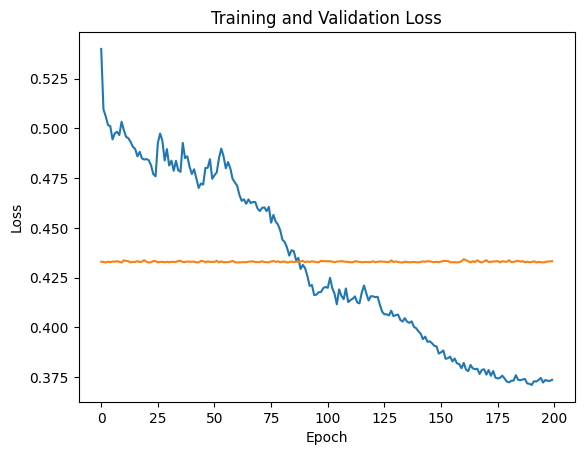

In [41]:
# Plot losses
a = []
for i in range(len(loss_track)):
    a.append(loss_track[i].item())

plt.plot(range(len(a)), a, label="Training Loss")
plt.plot(range(len(valid_loss)), valid_loss, label="Validation Loss")

plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

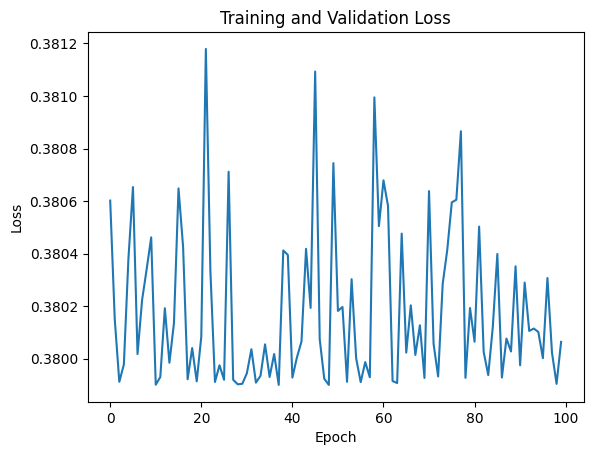

In [542]:
a = []
for i in range(len(valid_loss)):
    a.append(valid_loss[i])

plt.plot(range(len(a)), a, label="Training Loss")
# plt.plot(range(len(loss_track_valid)), loss_track_valid, label="Validation Loss")

plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [146]:
for i, v in enumerate(eval_dataloader):
    first_input = v[0]
    first_label = v[1]
    break

print(first_label)

model.eval()
a = model(first_input.to(device))
a

tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])


tensor([[ 1.0738e-01,  2.1376e-01],
        [-5.2824e-02,  2.4944e-02],
        [ 2.4760e-01,  3.2148e-01],
        [-5.6682e-03,  2.4677e-02],
        [-1.3484e-01,  5.6942e-01],
        [-3.7618e-02, -4.3268e-02],
        [ 3.2278e-01,  5.7808e-02],
        [ 2.3642e-01,  8.5187e-02],
        [ 7.5810e-02,  4.1966e-01],
        [-5.1099e-02, -3.8892e-04]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [115]:
print(loss_track[4])

tensor(-0., device='cuda:0', grad_fn=<DivBackward1>)


In [83]:
torch.save(model.state_dict(), "absence_smote_trained.pt")